In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import findspark
findspark.init()
import pyspark
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.clustering import KMeans

In [3]:
conf = SparkConf().setMaster("local[*]")
sc = SparkContext(conf=conf)

In [4]:
spark = SparkSession\
    .builder\
    .appName("MyApp")\
    .getOrCreate()

## Load the dataset

In [5]:
df = spark.read\
    .format("csv")\
    .option("header", "true")\
    .option("inferschema", "true")\
    .option("delimiter",",")\
    .load("Datasets/Optical-Signals.dat")#.repartition(3)

## Explore the dataset

In [6]:
df.show(5)

+-------------+-------------+
|        Power|    Frequency|
+-------------+-------------+
|32.3985896582| 535.22954715|
| 44.124688322| 69.598168224|
|40.7678894112|485.462483569|
|11.5013060329|350.502873036|
|10.8332547261|  286.5863951|
+-------------+-------------+
only showing top 5 rows



In [7]:
df.printSchema()

root
 |-- Power: double (nullable = true)
 |-- Frequency: double (nullable = true)



In [8]:
df.describe().show()

+-------+------------------+-----------------+
|summary|             Power|        Frequency|
+-------+------------------+-----------------+
|  count|               300|              300|
|   mean|31.646270907458085|318.1562129525923|
| stddev|15.838531976157299|152.4377851134495|
|    min|   0.0830253416479|   0.136728172461|
|    max|     59.2722587027|    576.917502506|
+-------+------------------+-----------------+



## Plot the dataset

In [9]:
x = df.toPandas() 

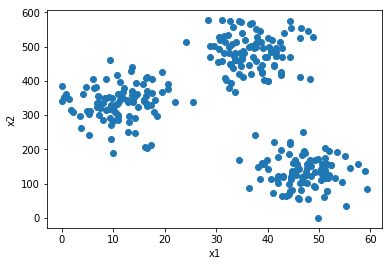

In [10]:
plt.scatter(x["Power"],x["Frequency"])
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Apply Vector Assembler

In [11]:
features = df.columns[0:len(df.columns)]
features

['Power', 'Frequency']

In [12]:
assembler = VectorAssembler()\
    .setInputCols(features)\
    .setOutputCol("features")

In [13]:
df_v = assembler.transform(df).select(col("features"))
df_v.show(10)

+--------------------+
|            features|
+--------------------+
|[32.3985896582,53...|
|[44.124688322,69....|
|[40.7678894112,48...|
|[11.5013060329,35...|
|[10.8332547261,28...|
|[11.9740993624,36...|
|[37.5992528754,24...|
|[30.8355231913,52...|
|[7.12843795962,30...|
|[20.6253232551,39...|
+--------------------+
only showing top 10 rows



## Scale the features

In [14]:
scaler = StandardScaler()\
    .setInputCol("features")\
    .setOutputCol("scaledFeatures")

In [15]:
df_s = scaler.fit(df_v).transform(df_v)\
    .select(col("scaledFeatures").alias("features"))

## Train the model

In [16]:
kmeans = KMeans().setK(3)

In [17]:
model = kmeans.fit(df_s)

In [18]:
model.clusterCenters()

[array([2.3231904 , 3.18218507]),
 array([2.96042125, 0.87588067]),
 array([0.71055579, 2.20329944])]

In [19]:
model.computeCost(df_s)

61.07180765121573

## Plot predictions

In [20]:
predictions = model.transform(df_s).select("prediction")
predictions.show(10)

+----------+
|prediction|
+----------+
|         0|
|         1|
|         0|
|         2|
|         2|
|         2|
|         1|
|         0|
|         2|
|         2|
+----------+
only showing top 10 rows



In [21]:
y = predictions.collect()
y = [y[row][0] for row in range(0,len(y))]

In [22]:
color = []
for j in y:
    if j==0:
        color.append('blue')
    elif j==1:
        color.append('red')
    else:
        color.append('green')

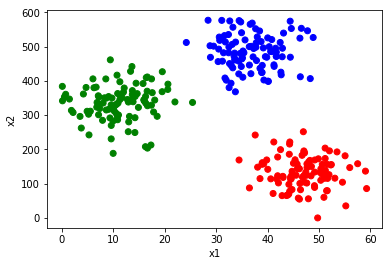

In [23]:
plt.scatter(x["Power"],x["Frequency"],c=color)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()